## Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense,
    Activation, Add, Multiply, Permute, Concatenate, Conv2D, Lambda
)
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, precision_recall_curve
import warnings
import time
warnings.filterwarnings("ignore")


import os

2025-11-23 08:34:29.547553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763886869.817871      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763886869.897434      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
import shutil
import os

path = "/kaggle/working/PRETRAINED_WEIGHTS"

# Delete folder if it exists
if os.path.exists(path):
    shutil.rmtree(path)
    print("🗑️ Deleted PRETRAINED_WEIGHTS folder and all contents.")
else:
    print("⚠️ Folder does not exist:", path)


⚠️ Folder does not exist: /kaggle/working/PRETRAINED_WEIGHTS


## Download PRETRAINED_WEIGHTS

In [3]:


# -----------------------------------------------------------
# Create PRETRAINED_WEIGHTS folder
# -----------------------------------------------------------
PRETRAINED_DIR = "/kaggle/working/PRETRAINED_WEIGHTS"
os.makedirs(PRETRAINED_DIR, exist_ok=True)

# -----------------------------------------------------------
# Model weights URLs
# -----------------------------------------------------------
WEIGHT_URL_1 = "https://github.com/Mehwish4593/RetinaLiteNet/raw/main/MTLTransfuseep300bs16head4.h5"
WEIGHT_URL_2 = "https://github.com/AbdullahButt-00/RetinalSegNet/blob/main/Inference/Model_weights_IOSTAR.h5"  

# -----------------------------------------------------------
# Paths to save weights
# -----------------------------------------------------------
WEIGHT_PATH_1 = os.path.join(PRETRAINED_DIR, "Model_weights_DRIVE.h5")
WEIGHT_PATH_2 = os.path.join(PRETRAINED_DIR, "Model_weights_IOSTAR.h5")

# -----------------------------------------------------------
# Download weights
# -----------------------------------------------------------
print("📥 Downloading pretrained model weights...")

!wget -O {WEIGHT_PATH_1} {WEIGHT_URL_1}
!wget -O {WEIGHT_PATH_2} {WEIGHT_URL_2}

print("\n✅ Download completed!")
print("Saved files:")
print(" -", WEIGHT_PATH_1)
print(" -", WEIGHT_PATH_2)


📥 Downloading pretrained model weights...
--2025-11-23 08:34:50--  https://github.com/Mehwish4593/RetinaLiteNet/raw/main/MTLTransfuseep300bs16head4.h5
Resolving github.com (github.com)... 4.237.22.38
Connecting to github.com (github.com)|4.237.22.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mehwish4593/RetinaLiteNet/main/MTLTransfuseep300bs16head4.h5 [following]
--2025-11-23 08:34:51--  https://raw.githubusercontent.com/Mehwish4593/RetinaLiteNet/main/MTLTransfuseep300bs16head4.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358496 (350K) [application/octet-stream]
Saving to: ‘/kaggle/working/PRETRAINED_WEIGHTS/Model_weights_DRIVE.h5’

/kaggle/working/PRE 100%[===================>] 350.

## CUSTOM METRICS & LOSS FUNCTIONS

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K, layers, models
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Reshape, Add, Activation, Multiply, Permute, Lambda,
                                     Concatenate, Conv2D, Conv2DTranspose, BatchNormalization)
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
from sklearn.metrics import precision_recall_curve, confusion_matrix

# --------------------------- Metrics ---------------------------
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    return tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))

def iou(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return intersection / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)

def dice_coef(y_true, y_pred, threshold=0.5):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def DiceLoss(y_true, y_pred, smooth=1e-6):
    y_true, y_pred = tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)
    nominator = 2 * tf.reduce_sum(y_pred * y_true) + smooth
    denominator = tf.reduce_sum(y_pred**2) + tf.reduce_sum(y_true**2) + smooth
    return 1 - nominator / denominator

def bcc_Jaccard_coef_loss(y_true, y_pred):
    return DiceLoss(y_true, y_pred) + (1 - iou(y_true, y_pred, threshold=0.5))

# --------------------------- CBAM ---------------------------
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3,1,2))(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1,
                          padding='same', activation='sigmoid',
                          kernel_initializer='he_normal', use_bias=False)(concat)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3,1,2))(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])


## MODEL ARCHITECTURE

In [ ]:

# --------------------------- TransFuse Model ---------------------------
def create_transfuse_net(input_shape, key_dim=32):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(8, 3, padding='same', activation='relu')(inputs)
    conv1 = layers.MaxPooling2D(2)(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    
    conv2 = layers.Conv2D(16, 3, padding='same', activation='relu')(conv1)
    conv2 = layers.MaxPooling2D(2)(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    
    conv3 = layers.Conv2D(32, 3, padding='same', activation='relu')(conv2)
    conv3 = layers.MaxPooling2D(2)(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    
    # Transformer
    transformer_block = layers.Reshape((-1, conv3.shape[3]))(conv3)
    transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=key_dim)(transformer_block, transformer_block)
    transformer_block = layers.GlobalAveragePooling1D()(transformer_block)
    transformer_block = layers.Reshape((1,1,transformer_block.shape[1]))(transformer_block)
    transformer_block = layers.Lambda(lambda x: tf.tile(x, [1, conv3.shape[1], conv3.shape[2], 1]))(transformer_block)
    
    att1 = cbam_block(transformer_block)
    fused_features = layers.Concatenate()([conv3, att1])
    
    # Decoder
    dec1 = layers.Conv2DTranspose(32,3,strides=2,padding='same',activation='relu')(fused_features)
    att2 = cbam_block(dec1)
    dec1 = layers.Concatenate()([att2, conv2])
    dec1 = layers.Conv2D(32,3,padding='same',activation='relu')(dec1)
    
    dec2 = layers.Conv2DTranspose(16,3,strides=2,padding='same',activation='relu')(dec1)
    att3 = cbam_block(dec2)
    dec2 = layers.Concatenate()([att3, conv1])
    dec2 = layers.Conv2D(16,3,padding='same',activation='relu')(dec2)
    
    dec3 = layers.Conv2DTranspose(8,3,strides=2,padding='same',activation='relu')(dec2)
    dec3 = layers.Conv2D(8,3,padding='same',activation='relu')(dec3)
    
    output_BV = layers.Conv2D(1,1,activation='sigmoid',name='final_output1')(dec3)
    output_OD = layers.Conv2D(1,1,activation='sigmoid',name='final_output2')(dec3)
    
    model = models.Model(inputs=inputs, outputs=[output_BV, output_OD])
    return model




## Data Loader

In [ ]:
# --------------------------- Data Loader ---------------------------
def get_data(path, im_height=512, im_width=512):
    images_path = os.path.join(path,'images')
    masks_path = os.path.join(path,'mask')
    
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.tif','.png','.jpg'))])
    n = len(image_files)
    
    X = np.zeros((n, im_height, im_width, 3), dtype=np.float32)
    y = np.zeros((n, im_height, im_width,1), dtype=np.float32)
    
    for i, img_name in enumerate(image_files):
        img = img_to_array(load_img(os.path.join(images_path,img_name),color_mode='rgb'))
        X[i] = resize(img,(im_height,im_width,3),preserve_range=True)/255.0
        
        mask_name = img_name.replace('.tif','_mask.gif').replace('.png','_mask.gif').replace('.jpg','_mask.gif')
        mask_path = os.path.join(masks_path, mask_name)
        if os.path.exists(mask_path):
            mask = img_to_array(load_img(mask_path,color_mode='grayscale'))
            y[i] = resize(mask,(im_height,im_width,1),preserve_range=True)/255.0
        else:
            y[i] = np.zeros((im_height,im_width,1),dtype=np.float32)
    
    return X, y


## Metrics Evaluation 

In [ ]:
# --------------------------- Metrics Evaluation ---------------------------
def evaluate_metrics(y_test, y_pred):
    n = y_pred.shape[0]
    all_F1, all_dice, all_jaccard, all_sens, all_spec = [np.zeros(n) for _ in range(5)]
    
    for i in range(n):
        gt, pred = y_test[i].flatten(), y_pred[i].flatten()
        precisions, recalls, thresholds = precision_recall_curve(gt,pred)
        f1 = 2*(precisions*recalls)/(precisions+recalls+1e-10)
        max_idx = np.argmax(f1)
        thres = thresholds[max_idx] if max_idx < len(thresholds) else 0.5
        pred_label = (pred>=thres).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(gt,pred_label).ravel()
        
        all_F1[i] = tp/(tp + 0.5*(fp+fn)+1e-10)
        all_dice[i] = 2*tp/(2*tp+fp+fn+1e-10)
        all_jaccard[i] = tp/(tp+fp+fn+1e-10)
        all_sens[i] = tp/(tp+fn+1e-10)
        all_spec[i] = tn/(tn+fp+1e-10)
    
    print(f'\nF1: {np.nanmean(all_F1):.4f}, Dice: {np.nanmean(all_dice):.4f}, '
          f'Jaccard: {np.nanmean(all_jaccard):.4f}, Sens: {np.nanmean(all_sens):.4f}, '
          f'Spec: {np.nanmean(all_spec):.4f}')
    
    return all_F1, all_dice, all_jaccard, all_sens, all_spec


# INFERENCE ON DRIVE DATASET

Creating model...


2025-11-23 08:34:52.456488: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Loading weights from: /kaggle/working/PRETRAINED_WEIGHTS/Model_weights_DRIVE.h5
Weights loaded successfully!

Loading test data from: /kaggle/input/drive-dataset01/test

Running inference...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Total Inference Time: 8.82 seconds
Inference Time per image: 0.4410 seconds

=== Blood Vessel Segmentation Metrics ===

F1: 0.9890, Dice: 0.9890, Jaccard: 0.9783, Sens: 0.9949, Spec: 0.9627

Predictions saved as 'predictions.png'


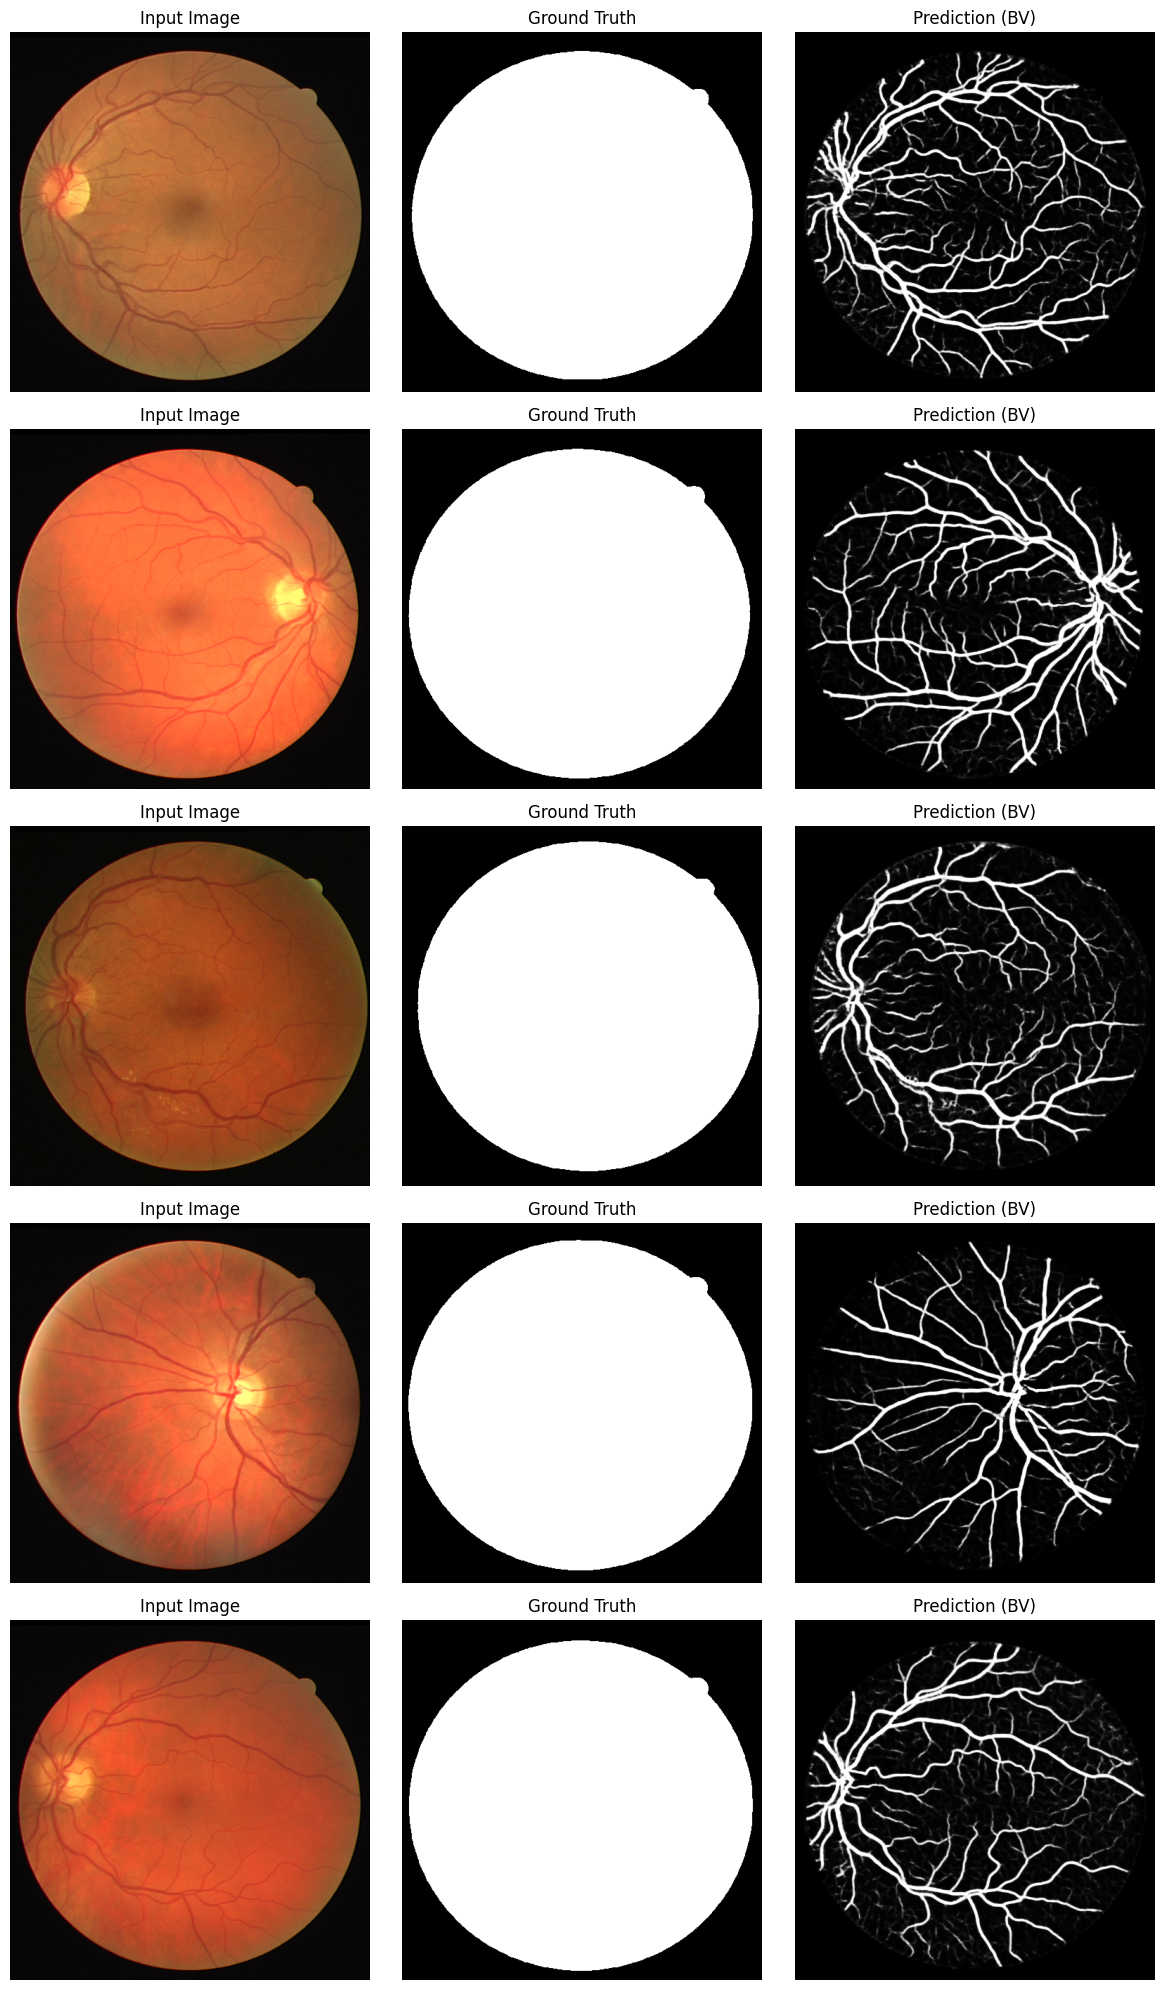


=== Evaluation Complete ===


In [5]:
if __name__ == "__main__":
    # Paths
    weights_path = '/kaggle/working/PRETRAINED_WEIGHTS/Model_weights_DRIVE.h5'
    test_data_path = '/kaggle/input/drive-dataset01/test'
    
    # Create model
    print("Creating model...")
    model = create_transfuse_net((512,512,3), key_dim=16)

    # model = create_transfuse_net(input_shape)
    
    
    # Compile model with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={'final_output1': bcc_Jaccard_coef_loss, 'final_output2': bcc_Jaccard_coef_loss},
        metrics={'final_output1': [dice_coef, iou, sensitivity, specificity],
                 'final_output2': [dice_coef, iou, sensitivity, specificity]}
    )
    
    # Load weights
    print(f"\nLoading weights from: {weights_path}")
    model.load_weights(weights_path)
    print("Weights loaded successfully!")
    
    # Load test data
    print(f"\nLoading test data from: {test_data_path}")
    X_test, y_test = get_data(test_data_path)
    
    # Convert ground truth to binary
    y_test_binary = (y_test > 0.5).astype(np.uint8)
    
    # Make predictions
    print("\nRunning inference...")
    start_time = time.time()
    predictions = model.predict(X_test, verbose=1)
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")
    print(f"Inference Time per image: {inference_time/len(X_test):.4f} seconds")
    
    # Evaluate metrics for BV (Blood Vessel) task
    print("\n=== Blood Vessel Segmentation Metrics ===")
    eval_BV = evaluate_metrics(y_test_binary, predictions[0])
    
    # Visualize some predictions
    num_samples = min(5, len(X_test))
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        if num_samples == 1:
            ax = axes
        else:
            ax = axes[i]
        
        ax[0].imshow(X_test[i])
        ax[0].set_title('Input Image')
        ax[0].axis('off')
        
        ax[1].imshow(np.squeeze(y_test_binary[i]), cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')
        
        ax[2].imshow(np.squeeze(predictions[0][i]), cmap='gray')
        ax[2].set_title('Prediction (BV)')
        ax[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("\nPredictions saved as 'predictions.png'")
    plt.show()
    
    print("\n=== Evaluation Complete ===")

# INFERENCE ON IOSTAR DATASET

Creating model...

Loading weights from: //kaggle/input/model-weights-iostar-h5/keras/default/1/re_training_model_weights.weights.h5
Weights loaded successfully!

Loading test data from: /kaggle/input/drive-dataset01/test

Running inference...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Total Inference Time: 8.19 seconds
Inference Time per image: 0.4093 seconds

=== Blood Vessel Segmentation Metrics ===

F1: 0.9729, Dice: 0.9729, Jaccard: 0.9472, Sens: 0.9977, Spec: 0.8826

Predictions saved as 'predictions.png'


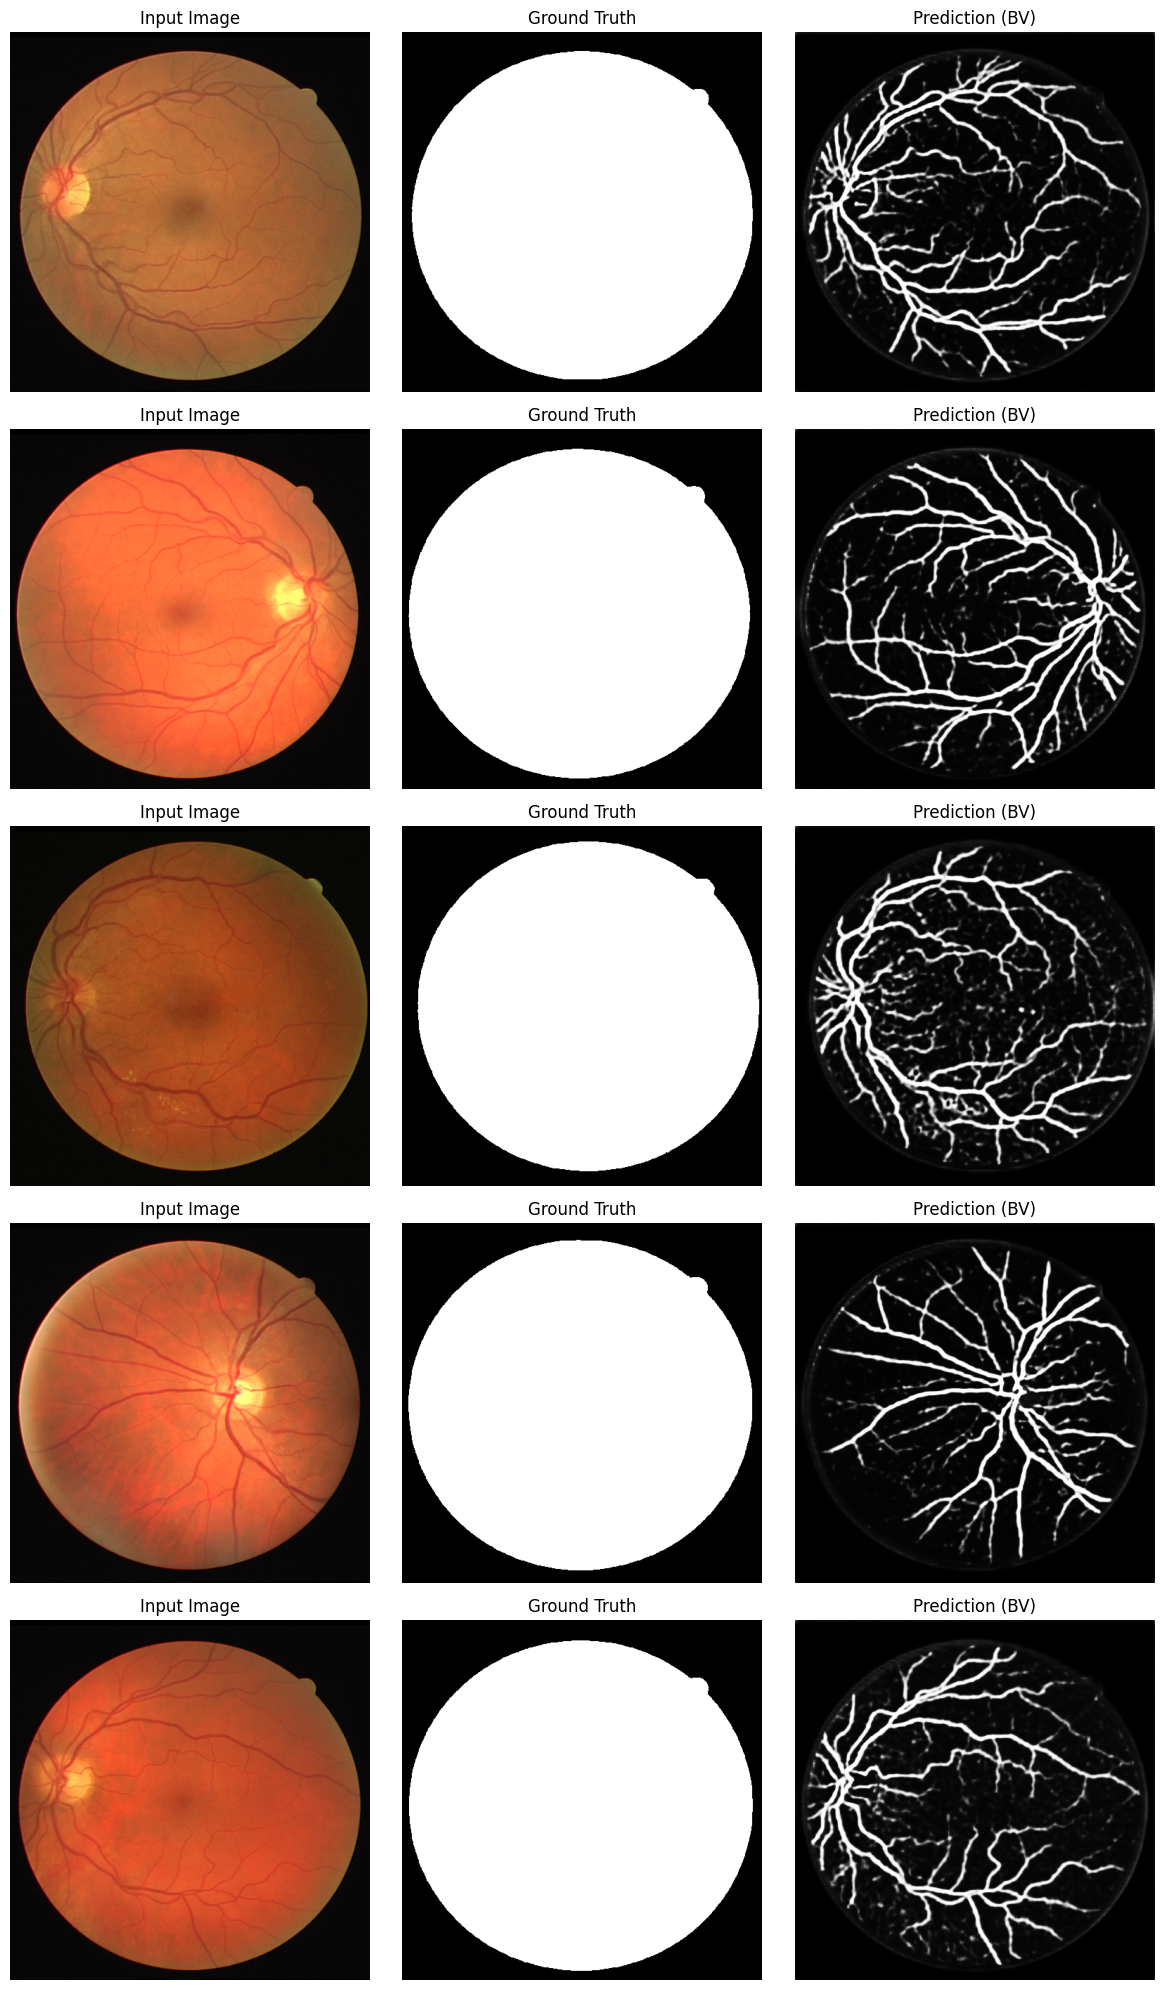


=== Evaluation Complete ===


In [6]:
if __name__ == "__main__":
    # Paths
    weights_path = '//kaggle/input/model-weights-iostar-h5/keras/default/1/re_training_model_weights.weights.h5'
    test_data_path = '/kaggle/input/drive-dataset01/test'
    
    # Create model
    input_shape = (512, 512, 3)
    print("Creating model...")
    model = create_transfuse_net(input_shape)
    
    # Compile model with custom metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss={'final_output1': bcc_Jaccard_coef_loss, 'final_output2': bcc_Jaccard_coef_loss},
        metrics={'final_output1': [dice_coef, iou, sensitivity, specificity],
                 'final_output2': [dice_coef, iou, sensitivity, specificity]}
    )
    
    # Load weights
    print(f"\nLoading weights from: {weights_path}")
    model.load_weights(weights_path)
    print("Weights loaded successfully!")
    
    # Load test data
    print(f"\nLoading test data from: {test_data_path}")
    X_test, y_test = get_data(test_data_path)
    
    # Convert ground truth to binary
    y_test_binary = (y_test > 0.5).astype(np.uint8)
    
    # Make predictions
    print("\nRunning inference...")
    start_time = time.time()
    predictions = model.predict(X_test, verbose=1)
    end_time = time.time()
    
    inference_time = end_time - start_time
    print(f"Total Inference Time: {inference_time:.2f} seconds")
    print(f"Inference Time per image: {inference_time/len(X_test):.4f} seconds")
    
    # Evaluate metrics for BV (Blood Vessel) task
    print("\n=== Blood Vessel Segmentation Metrics ===")
    eval_BV = evaluate_metrics(y_test_binary, predictions[0])
    
    # Visualize some predictions
    num_samples = min(5, len(X_test))
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i in range(num_samples):
        if num_samples == 1:
            ax = axes
        else:
            ax = axes[i]
        
        ax[0].imshow(X_test[i])
        ax[0].set_title('Input Image')
        ax[0].axis('off')
        
        ax[1].imshow(np.squeeze(y_test_binary[i]), cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[1].axis('off')
        
        ax[2].imshow(np.squeeze(predictions[0][i]), cmap='gray')
        ax[2].set_title('Prediction (BV)')
        ax[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
    print("\nPredictions saved as 'predictions.png'")
    plt.show()
    
    print("\n=== Evaluation Complete ===")

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ------------------------------------------------------------
# 1. COMPUTE FLOPs (TF2 compatible)
# ------------------------------------------------------------
def get_flops(model, input_shape=(1, 512, 512, 3)):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        tf.TensorSpec(input_shape, tf.float32)
    )

    frozen = convert_variables_to_constants_v2(concrete_func)
    graph = frozen.graph

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(
        graph=graph,
        run_meta=run_meta,
        options=opts
    )

    return flops.total_float_ops if flops else None


# ------------------------------------------------------------
# 2. COMPUTE MACs (manual, CNN-safe)
# ------------------------------------------------------------
def compute_macs(model):
    macs = 0
    for layer in model.layers:
        try:
            if isinstance(layer, tf.keras.layers.Conv2D):
                _, h, w, cin = layer.input_shape
                cout = layer.filters
                k = layer.kernel_size[0]
                macs += h * w * cin * cout * k * k

            elif isinstance(layer, tf.keras.layers.Conv2DTranspose):
                _, h, w, cout = layer.output_shape
                cin = layer.filters
                k = layer.kernel_size[0]
                macs += h * w * cin * cout * k * k
        except:
            pass
    return macs


# ------------------------------------------------------------
# 3. ACTIVATION MEMORY
# ------------------------------------------------------------
def get_activation_memory(model, input_shape=(1, 512, 512, 3)):
    total = 0
    x = tf.zeros(input_shape)

    for layer in model.layers:
        try:
            x = layer(x)
            total += np.prod(x.shape) * 4   # float32 = 4 bytes
        except:
            pass

    return total / (1024 * 1024)  # MB


# ------------------------------------------------------------
# 4. FULL PERFORMANCE REPORT PRINTER
# ------------------------------------------------------------
def generate_report(model, model_name="Model", input_shape=(1, 512, 512, 3)):
    print("\n" + "=" * 70)
    print(f"📊 PERFORMANCE REPORT — {model_name}")
    print("=" * 70)

    # Params
    params = model.count_params()
    size_mb = params * 4 / (1024 * 1024)

    # FLOPs
    flops = get_flops(model, input_shape)
    gflops = flops / 1e9 if flops else 0

    # MACs
    macs = compute_macs(model)
    gmacs = macs / 1e9

    # Activation Memory
    act_mem = get_activation_memory(model, input_shape)

    # PRINT SUMMARY
    print(f"📌 Total Parameters       : {params:,}")
    print(f"📌 Model Size (float32)   : {size_mb:.4f} MB")
    print(f"📌 FLOPs                  : {gflops:.4f} GFLOPs")
    print(f"📌 MACs                   : {gmacs:.4f} GMACs")
    print(f"📌 Activation Memory      : {act_mem:.4f} MB")
    print("=" * 70)
    print("Layer-wise summary:\n")
    model.summary()


# ------------------------------------------------------------
# 5. LOAD MODELS (DRIVE / IOSTAR)
# ------------------------------------------------------------
def evaluate_model(model_name, weights_path, input_shape=(512, 512, 3), key_dim=None):
    # # Your model builder
    # from model import create_transfuse_net

    print(f"\n🔧 Creating model: {model_name}...")
    if key_dim is None:
        model = create_transfuse_net(input_shape)
    else:
        model = create_transfuse_net(input_shape, key_dim=key_dim)

    print("📥 Loading weights...")
    model.load_weights(weights_path)

    print("✅ Weights loaded successfully.")

    # Generate report
    generate_report(
        model=model,
        model_name=model_name,
        input_shape=(1, input_shape[0], input_shape[1], input_shape[2])
    )

    return model




In [8]:
# ------------------------------------------------------------
# 6. RUN BOTH MODELS
# ------------------------------------------------------------

# DRIVE MODEL
evaluate_model(
    model_name="TransFuse (DRIVE)",
    weights_path="/kaggle/working/PRETRAINED_WEIGHTS/Model_weights_DRIVE.h5",
    input_shape=(512, 512, 3),
    key_dim=16
)




🔧 Creating model: TransFuse (DRIVE)...
📥 Loading weights...
✅ Weights loaded successfully.

📊 PERFORMANCE REPORT — TransFuse (DRIVE)


I0000 00:00:1763886930.973043      48 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1763886930.973225      48 single_machine.cc:361] Starting new session


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model g

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 512, 512,  │        224 │ input_layer_2[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 256, 256,  │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,168 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 128, 128,  │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_16          │ (None, 4096, 32)  │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4096, 32)  │      8,416 │ reshape_16[0][0], │
│ (MultiHeadAttentio… │                   │            │ reshape_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_17          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 64, 64,    │          0 │ reshape_17[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ lambda_14[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ lambda_14[0][0] 

 Total params: 57,810 (225.82 KB)

 Trainable params: 57,698 (225.38 KB)

 Non-trainable params: 112 (448.00 B)

<Functional name=functional_2, built=True>

In [9]:
# IOSTAR MODEL
evaluate_model(
    model_name="TransFuse (IOSTAR)",
    weights_path="/kaggle/input/model-weights-iostar-h5/keras/default/1/re_training_model_weights.weights.h5",
    input_shape=(512, 512, 3)
)



🔧 Creating model: TransFuse (IOSTAR)...
📥 Loading weights...
✅ Weights loaded successfully.

📊 PERFORMANCE REPORT — TransFuse (IOSTAR)


I0000 00:00:1763886932.139361      48 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1763886932.139540      48 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 512, 512,  │        224 │ input_layer_3[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 256, 256,  │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         32 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 256, 256,  │      1,168 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ max_pooling2d_10… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ max_pooling2d_11… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_24          │ (None, 4096, 32)  │          0 │ batch_normalizat… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4096, 32)  │     16,800 │ reshape_24[0][0], │
│ (MultiHeadAttentio… │                   │            │ reshape_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_25          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, 64, 64,    │          0 │ reshape_25[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ lambda_21[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ lambda_21[0][0] 

 Total params: 66,194 (258.57 KB)

 Trainable params: 66,082 (258.13 KB)

 Non-trainable params: 112 (448.00 B)

<Functional name=functional_3, built=True>